In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import pycatch22 as ct
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [ ]:
colnames=['DN_HistogramMode_5',
  'DN_HistogramMode_10',
  'CO_f1ecac',
  'CO_FirstMin_ac',
  'CO_HistogramAMI_even_2_5',
  'CO_trev_1_num',
  'MD_hrv_classic_pnn40',
  'SB_BinaryStats_mean_longstretch1',
  'SB_TransitionMatrix_3ac_sumdiagcov',
  'PD_PeriodicityWang_th0_01',
  'CO_Embed2_Dist_tau_d_expfit_meandiff',
  'IN_AutoMutualInfoStats_40_gaussian_fmmi',
  'FC_LocalSimple_mean1_tauresrat',
  'DN_OutlierInclude_p_001_mdrmd',
  'DN_OutlierInclude_n_001_mdrmd',
  'SP_Summaries_welch_rect_area_5_1',
  'SB_BinaryStats_diff_longstretch0',
  'SB_MotifThree_quantile_hh',
  'SC_FluctAnal_2_rsrangefit_50_1_logi_prop_r1',
  'SC_FluctAnal_2_dfa_50_1_2_logi_prop_r1',
  'SP_Summaries_welch_rect_centroid',
  'FC_LocalSimple_mean3_stderr']

In [ ]:
# This reads in each patient CSV and creates a dataframe from it
folderpath = r"C:\Users\colek\Downloads\mybox-selected (2)\mybox-selected"
series_list = []
for path in os.listdir(folderpath):
    df = pd.read_csv(os.path.join(folderpath,path))
    df.insert(0,"Patient",path)
    series_list.append(df[["Patient","Milliseconds since session start","HR-HR(bpm)","RR-RR(rpm)","SpO2-O2(%)"]].iloc[0:3600])
patient_df = pd.concat(series_list)

In [ ]:
patient_df.replace("?",np.nan,inplace=True) # Replace all "?" with np.NaN

In [ ]:
patient_df.reset_index(drop=True,inplace=True)
patient_df.dropna(inplace=True) # Dropping Null values

In [ ]:
patient_df[["HR-HR(bpm)","RR-RR(rpm)"]]=patient_df[["HR-HR(bpm)","RR-RR(rpm)"]].astype(int)
patient_df["SpO2-O2(%)"] = patient_df["SpO2-O2(%)"].astype(float) # Converting values from strings to numericals

In [ ]:
label_df = pd.read_csv("Vision_Patient_Target_Data.csv",usecols=[1,2]) # DataFrame for Target Values

In [ ]:
patient_df = patient_df.merge(label_df) # Merging Targets

In [ ]:
# This Creates features for each patient and each signal
patients = patient_df["Patient"].unique()
df_list = []
for patient in patients:
    df = patient_df[patient_df["Patient"]==patient]

    HR_Features = ct.catch22_all(df["HR-HR(bpm)"])
    RR_Features = ct.catch22_all(df["RR-RR(rpm)"])
    SPO2_Features = ct.catch22_all(df["SpO2-O2(%)"])
    HR_df =pd.DataFrame(HR_Features["values"],index=HR_Features["names"]).T
    HR_df.columns = list('HR_' + col for col in HR_df.columns)
    RR_df =pd.DataFrame(RR_Features["values"],index=RR_Features["names"]).T
    RR_df.columns = list('RR_' + col for col in RR_df.columns)
    SPO2_df =pd.DataFrame(SPO2_Features["values"],index=SPO2_Features["names"]).T
    SPO2_df.columns = list('SPO2_' + col for col in SPO2_df.columns)
    feat_df = pd.concat([HR_df,RR_df,SPO2_df],axis=1)                
    feat_df.insert(0,"Patient",patient[:-4])
    feat_df.insert(0,"Target",df["label"].values[0])
    df_list.append(feat_df)

In [ ]:
train_data = pd.concat(df_list)

In [12]:
# HyperParameter Tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
X_train, X_test, y_train, y_test = train_test_split(train_data.drop(columns=["Patient","Target"]), train_data["Target"], test_size=0.2, random_state=42)
# Initialize the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)

# Set up Grid Search
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit Grid Search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_:.2f}")


Best Parameters: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150}
Best Score: 0.69


Accuracy: 0.93


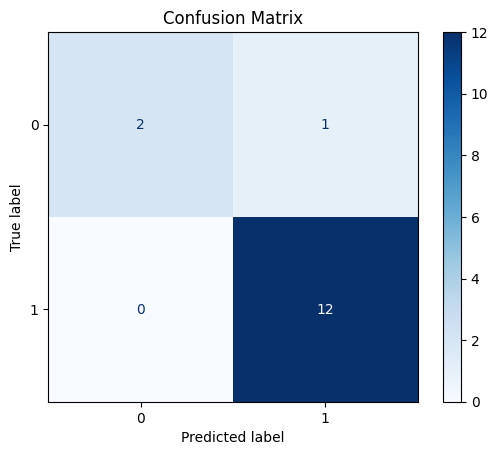

In [13]:


# Initialize the RandomForestClassifier
rf_clf = RandomForestClassifier(**{'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 150})

# Train the model
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred = rf_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Detailed classification report
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [14]:
X = train_data.drop(columns = ["Patient","Target"])
y= train_data["Target"]

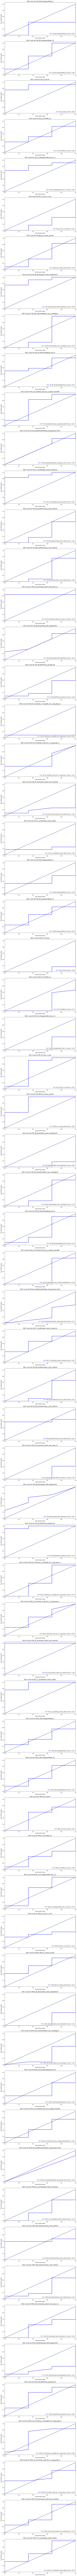

In [24]:
num_features = X_train.shape[1]
fig, axes = plt.subplots(nrows=num_features, figsize=(10, num_features * 5))

auc_for_each_feature = []

# Plot ROC curves for each feature in a separate subplot
for i in range(num_features):
    # Handle the case where there's only one feature (axes will not be an array)
    ax = axes[i] if num_features > 1 else axes
    
    # Use the ith feature as the predictor
    fpr, tpr, thresholds = roc_curve(y_test, X_test.iloc[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Save feature name and AUC score
    feature_and_auc = {"Feature":X_train.columns[i], "AUC":roc_auc}
    auc_for_each_feature.append(feature_and_auc)
    
    # Plot the ROC curve for the ith feature
    ax.plot(fpr, tpr, color='blue', lw=2, label=f'{X_train.columns[i]} (area = {roc_auc:.2f})')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'ROC Curve for {X_train.columns[i]}')
    ax.legend(loc='lower right')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

In [16]:
pd.DataFrame(auc_for_each_feature).to_c

[['HR_DN_HistogramMode_5', np.float64(0.27777777777777785)],
 ['HR_DN_HistogramMode_10', np.float64(0.5833333333333334)],
 ['HR_CO_f1ecac', np.float64(0.8611111111111112)],
 ['HR_CO_FirstMin_ac', np.float64(0.5555555555555556)],
 ['HR_CO_HistogramAMI_even_2_5', np.float64(0.8055555555555556)],
 ['HR_CO_trev_1_num', np.float64(0.19444444444444448)],
 ['HR_MD_hrv_classic_pnn40', np.float64(0.41666666666666674)],
 ['HR_SB_BinaryStats_mean_longstretch1', np.float64(0.888888888888889)],
 ['HR_SB_TransitionMatrix_3ac_sumdiagcov', np.float64(0.38888888888888895)],
 ['HR_PD_PeriodicityWang_th0_01', np.float64(0.6666666666666666)],
 ['HR_CO_Embed2_Dist_tau_d_expfit_meandiff', np.float64(0.6666666666666667)],
 ['HR_IN_AutoMutualInfoStats_40_gaussian_fmmi', np.float64(0.5)],
 ['HR_FC_LocalSimple_mean1_tauresrat', np.float64(0.9166666666666666)],
 ['HR_DN_OutlierInclude_p_001_mdrmd', np.float64(0.2777777777777778)],
 ['HR_DN_OutlierInclude_n_001_mdrmd', np.float64(0.2777777777777778)],
 ['HR_SP_Su

In [ ]:
train_data.to_csv("Catch22_Vision_Data.csv")

In [17]:
thresholds

array([       inf, 0.36152769, 0.32599326, 0.3025415 , 0.26095076,
       0.25816192, 0.21040079, 0.1713722 ])